In [9]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

2.15.0


In [6]:
import numpy as np
categories = np.load('categories.npy')
data = np.load('training_data.npy')
periods =np.load('valid_periods.npy')
categories.shape,data.shape,periods.shape

((48000,), (48000, 2776), (48000, 2))

In [7]:
X_train_raw =data

Avg Series Length   198 

values greater than avg length 23101


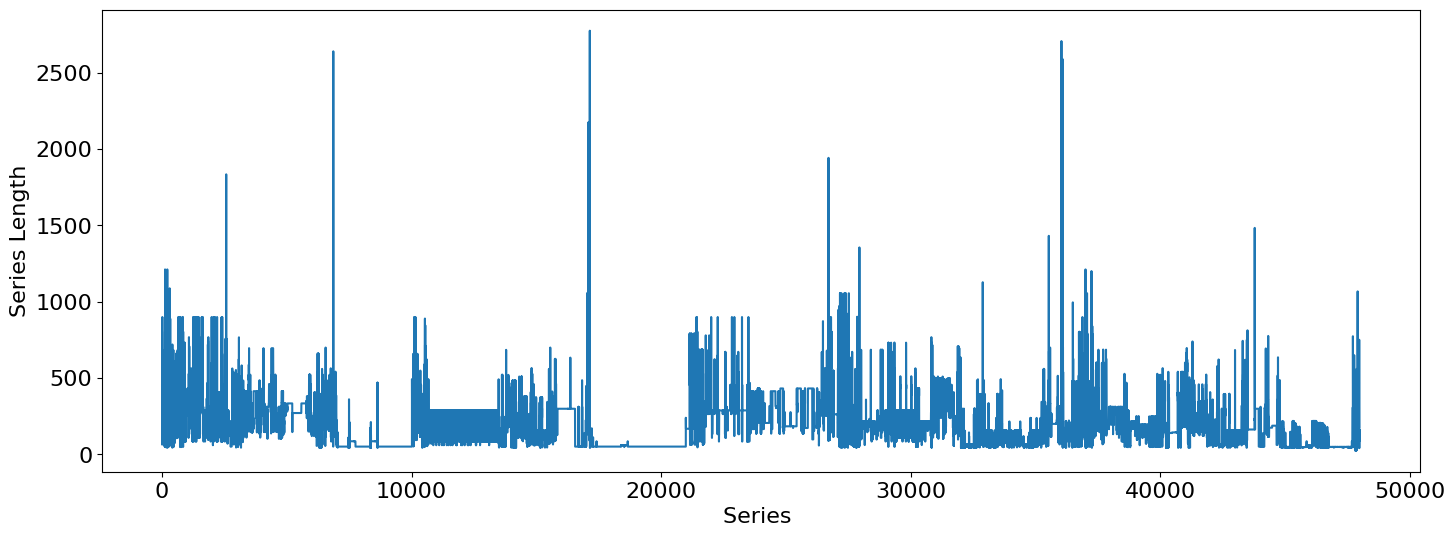

In [17]:
period_len=periods[:,1]-periods[:,0]
print("Avg Series Length  ",int(np.average(period_len)) ,"\nvalues greater than avg length",np.count_nonzero(period_len > np.average(period_len)))

plt.figure(figsize=(17,6))
plt.plot(period_len)
plt.xlabel("Series ")
plt.ylabel("Series Length")

plt.show()


In [18]:
np.unique(categories, return_counts=True)


(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([ 5728, 10987, 10017, 10016, 10975,   277]))

Preprocess1

Taking values just from index 1500 and above as for most sequences the values are 0 at indexes <1500


In [ ]:
def build_sequences1(df,window=200, stride=20, telescope=80):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []

    for i in df:
        idx=1500
        while idx+window +telescope < len(i):
            dataset.append(i[idx:idx+window])
            labels.append(i[idx+window:idx+window+telescope])
            idx=idx+stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

Preprocess2

Taking all meaningful values from the dataset using periods data.


In [ ]:
def build_sequences2(df,window=200, stride=20, telescope=80):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []


    k=0
    for i in df:
        idx=periods[k][0]
        # to include zero values
        if idx>=30:
            idx=idx-15
        while idx+window +telescope < len(i):
            dataset.append(i[idx:idx+window])
            labels.append(i[idx+window:idx+window+telescope])
            idx=idx+stride
        k+=1
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
window=200 #or 20
stride=5 #or 1
direct_telescope=10 or #2

In [ ]:
X_train, y_train = build_sequences1(X_train_raw, window, stride, direct_telescope)
X_train.shape, y_train.shape

In [ ]:
X_train = X_train.reshape((len(X_train), 200,1))
y_train = y_train.reshape((len(y_train), 10,1))

In [40]:
def build1(input_shape):


    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x =tfkl.Bidirectional(tfkl.LSTM(200, return_sequences=True, name='lstm'), name='bidirectional_lstm')(inputs)

    x =tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=False, name='lstm1'), name='bidirectional_lstm1')(x)


    x= tfkl.Dense(units=512,activation='relu')(x)

    drop = tfkl.Dropout(0.2)(x)
    x= tfkl.Dense(units=1024,activation='relu')(drop)

    drop1 = tfkl.Dropout(0.2)(x)

    output = tfkl.Dense(units=10,activation='linear')(drop1)


    model = tf.keras.Model(inputs=inputs, outputs=output, name='k_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))
    #model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
def build2(input_shape):


    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x =tfkl.LSTM(200, return_sequences=False, name='lstm')(inputs)


    x= tfkl.Dense(units=512,activation='relu')(x)


    output = tfkl.Dense(units=10,activation='relu')(x)


    model = tf.keras.Model(inputs=inputs, outputs=output, name='k_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))
    #model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
def build3(input_shape):


    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x =tfkl.LSTM(64, return_sequences=False, name='lstm')(inputs)


    x= tfkl.Dense(units=128,activation='relu')(x)


    output = tfkl.Dense(units=10,activation='relu')(x)


    model = tf.keras.Model(inputs=inputs, outputs=output, name='k_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))
    #model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
batch_size = 3000
epochs = 200
# Train the model using Multi GPU
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build(X_train.shape[1:]) # or build2 or build3
    model.summary()
    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_split=.15,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=9, factor=0.1, min_lr=1e-5),
            tf.keras.callbacks.ModelCheckpoint("model.h5", monitor="val_loss",
            save_best_only=False, period=5)
        ]
    ).history

In [ ]:

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('model')

In [ ]:
del model
import gc
gc.collect()

10846

Normal prediction for N values. Slicing to output only 9 values & 18 values


In [ ]:
class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X, categories):

        # Note: this is just an example.
        # Here the model.predict is called
        out = self.model.predict(X)  # Shape [BSx9] for Phase 1 and [BSx18] for Phase 2
        out = out[:,:9]
        return out

Sliding prediction aproach. Predict N values.

In [ ]:

import os
import tensorflow as tf
import numpy as np
class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X, categories):

        # Note: this is just an example.
        # Here the model.predict is called
        total_pred=9 or #18
        window=20
        out=[]
        for i in range(total_pred):
          r = self.model.predict(X[:,i:window+i])
          r=r[:,0]
          r=np.reshape(r, (len(X),1))
          X = np.hstack((X, r))
          out.append(r)
        out = np.array(out)
        out= out.reshape(total_pred,len(X))
        out= out.T
        return out


Defining values for testing

In [ ]:
tst=[]
res=[]
cat=[]
for i in range(100):
    rand1 = int(random.uniform(2400, 2515))
    rand2 = int(random.uniform(0, 48000))
    cat.append(categories[rand2])
    tst.append(data[rand2][rand1:rand1+200])
    res.append(data[rand2][rand1+200:rand1+200+18])
tst=np.array(tst)
res=np.array(res)
tst.shape,res.shape,tst[0]

In [27]:
mod=model('')
predictions= mod.predict(tst[0:60],cat)
total_pred=9 #or 18
# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(res[:60,:total_pred].flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(res[:60,:total_pred].flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

2/2 [==============================] - 2s 27ms/step

Predictions shape: (60, 9)

Mean Squared Error: 0.005947677418589592

Mean Absolute Error: 0.0449308343231678


GRU Model: This model scored MSE= 0.00587 and MAE = 0.00545 in codalab during the development phase. For the the final phase we changed the forecast length
and trained the model again. The model was able to score MSE= 0.0115 and MAE = 0.0743


In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # hopefully nothing explodes

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
print(tf.version)
print(tf.config.list_physical_devices('GPU'))

# For reproducible results
os.environ['PYTHONHASHSEED']=str(42)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42) 

In [ ]:
val_size = 0.2
data_path = '/kaggle/input/time-series-data/'
seq_length = 26      # predictions based on previous seq_length data entries
forecast_length = 18  # predicting forecast_length time steps into the future
sample_length = seq_length + forecast_length


# Read data
categories = np.load(os.path.join(data_path, 'categories.npy'))
training_data = np.load(os.path.join(data_path, 'training_data.npy'))
valid_periods = np.load(os.path.join(data_path, 'valid_periods.npy'))

# Filter out unvalid data
data = []
for i, row in enumerate(training_data):
    data.append(row[valid_periods[i][0]:valid_periods[i][1]])

# Encode categories
num_categories = len(np.unique(categories))
v_char_to_float = np.vectorize(lambda char : (ord(char)-ord('A'))/(num_categories-1)) # maps A-F to 0-1
float_categories = v_char_to_float(categories)

print(float_categories.shape, f"({len(data)}, -)", valid_periods.shape)

In [ ]:
# Convert time series to {x: sequences of length seq_length, y: values to be predicted from previous sequence}
# the category is repeated for each point in the time series
def to_sequences(time_series, category):
    
    x = []
    y = []
    
    for i in range(time_series.shape[0]-seq_length-forecast_length+1):
        x_time_column = time_series[i:i+seq_length]
        x_category_column = np.full_like(x_time_column, fill_value=category)
        x.append(np.column_stack((x_time_column, x_category_column)))
        y.append(time_series[i+seq_length:i+seq_length+forecast_length])  
    
    return {'x': np.array(x), 'y': np.array(y)}

# Shuffle the lists, while keeping corresponding data,category together (e.g data[0] -> data[1337] <=> cat[0] -> cat[1337])
dc = list(zip(data, float_categories))
random.shuffle(dc)
data, float_category = zip(*dc)
 
# Build sequences from the non-correlated time series, and append them to corresponding data set
# Note: there is no overlap between train and validation; each processed time series is used in train xor val
X_train, X_val = [], []
y_train, y_val = [], []
split_index = int((1-val_size)*len(data))
for i, time_series in enumerate(data): 
    if (len(time_series) >= sample_length): # assert we can draw at least one sample from the time_series
        sequences = to_sequences(time_series, float_categories[i])
        if(i < split_index):
            X_train.append(sequences['x']) 
            y_train.append(sequences['y'])   
        else:
            X_val.append(sequences['x']) 
            y_val.append(sequences['y'])  

# Convert lists to nparrays 
X_train = np.concatenate(X_train, axis=0)
X_val = np.concatenate(X_val, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [ ]:
input_size = (X_train.shape[1], X_train.shape[2])
batch_size = 128
epochs = 1000
dout = 0.15

model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(96, input_shape=input_size),
    tf.keras.layers.Dropout(rate=dout),      # prevent overfitting
    tf.keras.layers.Dense(forecast_length)   # output is next forecast_length values
])

# Evaluate using MSE as loss function and the adam optimizer
model.compile(optimizer='adam', loss='mse')

# Stop training when validation loss stops improving, maintain best weights
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # how many epochs to check for improvement before stopping
    restore_best_weights=True,
)

history = model.fit(X_train,
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=callback,
                    verbose=1)

# Evaluate on validation data
val_result = model.evaluate(X_val, y_val, verbose=0)
print(f"Val loss (MSE): {val_result}")g

In [ ]:
best_epoch = np.argmax(history.history['loss'])


plt.figure(figsize=(17,4))
plt.plot(history.history['loss'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()



In [ ]:
# Val loss for each prediction step
y_pred = model.predict(X_val)
for t in range(forecast_length):
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(y_val[:, t], y_pred[:, t])
    print(f'Val loss (MSE) {t+1}h forward: {m.result().numpy()}')

In [ ]:
model.save('GRU')

In [ ]:
from sklearn.preprocessing import RobustScaler
import numpy as np

# Initialize RobustScaler
scaler = RobustScaler()

# Fit the scaler to the data and transform it
scaled_data = scaler.fit_transform(X_train_raw)
scaled_data

array([[ 0.        ,  0.        ,  0.        , ...,  0.09430767,
        -0.34525692, -0.40869137],
       [ 0.        ,  0.        ,  0.        , ...,  0.08934253,
        -0.18100513, -0.29562673],
       [ 0.        ,  0.        ,  0.        , ...,  0.73368526,
         0.68374718,  0.7227849 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.04236442,
         0.03626771, -0.02113975],
       [ 0.        ,  0.        ,  0.        , ..., -0.18664738,
         0.04205407, -0.281353  ],
       [ 0.        ,  0.        ,  0.        , ..., -0.01310895,
         0.08518247,  0.0469106 ]])

In [ ]:
def build_simple_rnn(input_shape):
    model = tf.keras.Sequential()
    
    # RNN layer
    model.add(tfkl.SimpleRNN(96, input_shape= input_shape))
    
    # Output layer
    model.add(tfkl.Dense(9, activation='softmax'))  # Adjust activation based on your task
   # model = tf.keras.Model(inputs=input_shape, outputs=output, name='k_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

In [ ]:
def build_resnet(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

   # First Conv1D block
    x = tfkl.Conv1D(64, 3, activation='relu', padding='same')(input_layer)
    x = tfkl.Conv1D(64, 3, activation='relu', padding='same')(x)

    # Residual connections
    residual = tfkl.Conv1D(64, 1, padding='same')(input_layer)
    x = tfkl.add([x, residual])
    x = tfkl.Activation('relu')(x)

    # Second Conv1D block
    x = tfkl.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = tfkl.Conv1D(128, 3, activation='relu', padding='same')(x)

    # Residual connections
    residual = tfkl.Conv1D(128, 1, padding='same')(x)
    x = tfkl.add([x, residual])
    x = tfkl.Activation('relu')(x)

    # Global average pooling
    x = tfkl.GlobalAveragePooling1D()(x)

    # Output layer
    outputs = tfkl.Dense(units=9,activation='linear')(x)  # Adjust output_size based on your task
    
    model = tf.keras.Model(inputs=input_layer, outputs=outputs, name='model')
    
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model= Sequential()
model.add(InputLayer((200, 1)))
model.add(Conv1D(96, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

In [ ]:
def build(input_shape):


# Add an LSTM layer with 50 units
    inputs = tfkl.Input(shape=input_shape, name='input_layer')
    model = Sequential()
   
    model.add(Conv1D(96, kernel_size=2))
    model.add(Flatten())
    model.add(Dense(8, 'relu'))
    output=model.add(Dense(1, 'linear'))
    #output = tfkl.Reshape((12,))(output)
    model = tf.keras.Model(inputs=inputs, outputs=output, name='k_model')

    #model = tf.keras.Model(inputs=inputs, outputs=output, name='k_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))
    #model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model
    

In [ ]:
batch_size = 3500
epochs = 200
# Train the model
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build(X_train.shape[1:])
    model.summary()
#y_train = np.squeeze(y_train, axis=-1)
    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_split=.15,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=9, factor=0.1, min_lr=1e-5),
            tf.keras.callbacks.ModelCheckpoint("model.h5", monitor="val_loss",
            save_best_only=False, period=5)
        ]
    ).history